In [1]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

deep_learning_spring_2025_project_2_path = kagglehub.competition_download('deep-learning-spring-2025-project-2')

print('Data source import complete.')


Data source import complete.


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
!pip install -U transformers
!pip install datasets
!pip install peft
!pip install evaluate

In [5]:
# -----------------------------
# 1. Import libraries
# -----------------------------
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset
from peft import get_peft_model, LoraConfig, TaskType
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import pickle

# -----------------------------
# 2. Use GPU if available
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -----------------------------
# 3. Load and preprocess AGNEWS dataset
# -----------------------------
dataset = load_dataset("ag_news")
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])


Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [6]:
# -----------------------------
# 4. Load RoBERTa model with LoRA adapters
# -----------------------------
model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=4)

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS
)

model = get_peft_model(model, lora_config)
model.to(device)
model.print_trainable_parameters()

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 888,580 || all params: 125,537,288 || trainable%: 0.7078


In [7]:
print(TrainingArguments.__module__)
print(transformers.__version__)

transformers.training_args
4.51.3


In [8]:
# -----------------------------
# 5. Define training arguments
# -----------------------------
training_args = transformers.TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="no",
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    optim="adamw_torch",
    num_train_epochs=3,
    warmup_steps=100,
    weight_decay=0.01,
    lr_scheduler_type="linear",
    logging_dir="./logs",
    report_to="none"
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, predictions)}

In [9]:
def get_trainer(model):
    return  Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


In [10]:
# -----------------------------
# 6. Train the model with Hyperparameter sweep
# -----------------------------

from peft import LoraConfig, get_peft_model, TaskType
import pandas as pd

EXPERIMENT = True  # True to sweep, False for default single run

results = []
trained_trainers = {}

grid = [(r, alpha)
        for r in [1, 2, 3, 4, 5]
        for alpha in [4, 8, 16, 32]]

if EXPERIMENT:
    # 1) Filter valid configs
    valid_configs = []
    for r, alpha in grid:
        cfg = LoraConfig(
            r=r,
            lora_alpha=alpha,
            lora_dropout=0.1,
            bias="none",
            target_modules=["query","key","value","dense"],
            task_type=TaskType.SEQ_CLS,
        )
        model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=4)
        model = get_peft_model(model, cfg)  # wrap into `model`
        trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
        if trainable <= 1_000_000:
            valid_configs.append((r, alpha))

    # 2) Train & evaluate each valid config
    for r, alpha in valid_configs:
        print(f"→ Training r={r}, α={alpha}")
        cfg = LoraConfig(
            r=r,
            lora_alpha=alpha,
            lora_dropout=0.1,
            bias="none",
            target_modules=["query","key","value","dense"],
            task_type=TaskType.SEQ_CLS,
        )
        model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=4)
        model = get_peft_model(model, cfg)  # assign to `model`
        model.print_trainable_parameters()

        trainer = get_trainer(model)
        trainer.train()
        metrics = trainer.evaluate(tokenized_dataset["test"])
        acc = metrics["eval_accuracy"]

        results.append({
            "r": r,
            "alpha": alpha,
            "trainable_params": sum(p.numel() for p in model.parameters() if p.requires_grad),
            "accuracy": acc,
        })
        trained_trainers[(r, alpha)] = trainer

    # 3) Aggregate & pick best
    df = pd.DataFrame(results).sort_values("accuracy", ascending=False).reset_index(drop=True)
    best_r, best_alpha = int(df.loc[0, "r"]), int(df.loc[0, "alpha"])
    best_trainer = trained_trainers[(best_r, best_alpha)]
    model = best_trainer.model  # final `model`

else:
    # Default single run: r=1, alpha=32
    best_r, best_alpha = 1, 32
    cfg = LoraConfig(
        r=best_r,
        lora_alpha=best_alpha,
        lora_dropout=0.1,
        bias="none",
        target_modules=["query","key","value","dense"],
        task_type=TaskType.SEQ_CLS,
    )
    model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=4)
    model = get_peft_model(model, cfg)
    print("Default run parameters:")
    model.print_trainable_parameters()

    trainer = get_trainer(model)
    trainer.train()
    metrics = trainer.evaluate(tokenized_dataset["test"])
    acc = metrics["eval_accuracy"]

    results = [{
        "r": best_r,
        "alpha": best_alpha,
        "trainable_params": sum(p.numel() for p in model.parameters() if p.requires_grad),
        "accuracy": acc,
    }]
    df = pd.DataFrame(results)
    best_trainer = trainer

# 4) Summary
print("Sweep/Default results:")
print(df)
print(f"\nSelected best → r={best_r}, α={best_alpha}, acc={df.loc[0,'accuracy']:.4f}")
# `model` and `best_trainer` now hold your final LoRA‑adapted, trained model


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN th

→ Training r=1, α=4


<ipython-input-9-35b25b8dd4ac>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  return  Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


trainable params: 761,092 || all params: 125,411,336 || trainable%: 0.6069


Epoch,Training Loss,Validation Loss,Accuracy
1,0.255900,0.236287,0.924868
2,0.216600,0.213357,0.933289
3,0.197400,0.213860,0.934342


→ Training r=1, α=8


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-9-35b25b8dd4ac>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  return  Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


trainable params: 761,092 || all params: 125,411,336 || trainable%: 0.6069


Epoch,Training Loss,Validation Loss,Accuracy
1,0.247900,0.231088,0.928289
2,0.211000,0.206855,0.937105
3,0.191600,0.206901,0.938421


→ Training r=1, α=16


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-9-35b25b8dd4ac>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  return  Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


trainable params: 761,092 || all params: 125,411,336 || trainable%: 0.6069


Epoch,Training Loss,Validation Loss,Accuracy
1,0.239000,0.215913,0.932632
2,0.208000,0.200216,0.939211
3,0.186700,0.203756,0.941184


→ Training r=2, α=4


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-9-35b25b8dd4ac>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  return  Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


trainable params: 928,516 || all params: 125,580,296 || trainable%: 0.7394


Epoch,Training Loss,Validation Loss,Accuracy
1,0.252000,0.234784,0.925263
2,0.212700,0.207800,0.933947
3,0.193300,0.207651,0.935263


→ Training r=2, α=8


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-9-35b25b8dd4ac>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  return  Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


trainable params: 928,516 || all params: 125,580,296 || trainable%: 0.7394


Epoch,Training Loss,Validation Loss,Accuracy
1,0.243300,0.224555,0.929868
2,0.206600,0.200159,0.936711
3,0.187200,0.201135,0.938421


→ Training r=2, α=16


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-9-35b25b8dd4ac>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  return  Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


trainable params: 928,516 || all params: 125,580,296 || trainable%: 0.7394


Epoch,Training Loss,Validation Loss,Accuracy
1,0.235700,0.211785,0.932500
2,0.202600,0.195941,0.939605
3,0.182600,0.198079,0.941579


Sweep/Default results:
   r  alpha  trainable_params  accuracy
0  2     16            928516  0.941579
1  1     16            761092  0.941184
2  2      8            928516  0.938421
3  1      8            761092  0.938421
4  2      4            928516  0.935263
5  1      4            761092  0.934342

Selected best → r=2, α=16, acc=0.9416


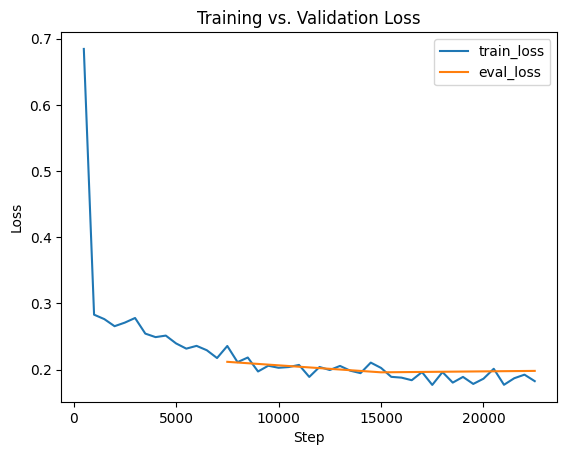

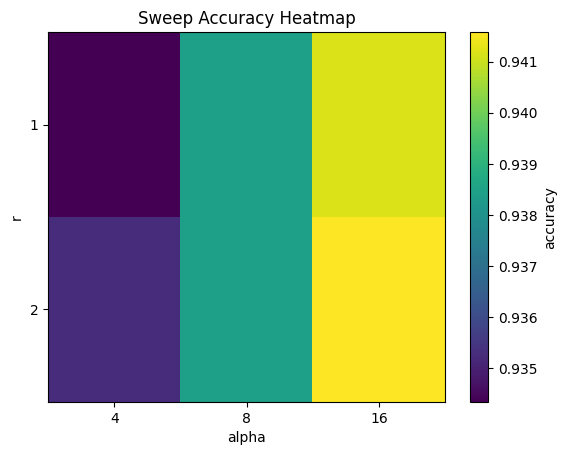

In [11]:
# -----------------------------
# 6.2 Visualization
# -----------------------------
import matplotlib.pyplot as plt

history = best_trainer.state.log_history

train_entries = [
    e for e in history
    if "loss" in e and "eval_loss" not in e
]
train_steps = [e["step"] for e in train_entries if "step" in e]
train_loss  = [e["loss"] for e in train_entries]

eval_entries = [e for e in history if "eval_loss" in e]
eval_steps = [e["step"] for e in eval_entries]
eval_loss  = [e["eval_loss"] for e in eval_entries]

plt.figure()
plt.plot(train_steps, train_loss, label="train_loss")
plt.plot(eval_steps,  eval_loss,  label="eval_loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.show()

pivot = df.pivot(index="r", columns="alpha", values="accuracy")

plt.figure()
plt.imshow(pivot, aspect="auto")
plt.xticks(range(len(pivot.columns)), pivot.columns)
plt.yticks(range(len(pivot.index)),   pivot.index)
plt.xlabel("alpha")
plt.ylabel("r")
plt.title("Sweep Accuracy Heatmap")
plt.colorbar(label="accuracy")
plt.show()

In [12]:
# -----------------------------
# 7. Evaluate the model
# -----------------------------
eval_results = best_trainer.evaluate()
print("Final Evaluation(Testing) Accuracy:", eval_results["eval_accuracy"])

Final Evaluation Accuracy: 0.9415789473684211


In [13]:
# -----------------------------
# 8. Check trainable parameter count
# -----------------------------
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")

Trainable parameters: 928516


In [16]:
from datasets import Dataset
from torch.utils.data import DataLoader

pickle_path = os.path.join(
    deep_learning_spring_2025_project_2_path,
    'test_unlabelled.pkl'
)
# Load dataset object
with open(pickle_path, "rb") as f:
    test_dataset = pickle.load(f)

# Convert to HuggingFace Dataset (already is, but this helps formatting)
test_dataset = Dataset.from_dict({"text": test_dataset["text"]})

# Tokenize function
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

# Apply tokenizer
tokenized_test_dataset = test_dataset.map(preprocess_function, batched=True)
tokenized_test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])

# Create PyTorch DataLoader for batching
test_dataloader = DataLoader(tokenized_test_dataset, batch_size=64)

# Prediction loop
model.eval()
all_predictions = []

with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=-1)
        all_predictions.extend(preds.cpu().numpy())
print("First 10 predictions:", all_predictions[:10])

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

First 10 predictions: [np.int64(3), np.int64(0), np.int64(0), np.int64(3), np.int64(1), np.int64(1), np.int64(3), np.int64(0), np.int64(3), np.int64(3)]


In [17]:
# -----------------------------
# 10. Save predictions to CSV
# -----------------------------
df = pd.DataFrame({
    "ID": list(range(len(all_predictions))),   # ID ✅
    "label": all_predictions
})
df.to_csv("submission.csv", index=False)
print("✅ Batched predictions complete. Saved to submission.csv.")

✅ Batched predictions complete. Saved to submission.csv.
